In [1]:
import sys
sys.path.append("./../..")


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.nn.modules.loss import _Loss
from torch import optim
import torchvision.datasets as datasets
import numpy as np
import math
import matplotlib.pyplot as plt
from misc.utils import count_parameters

### transform stuff

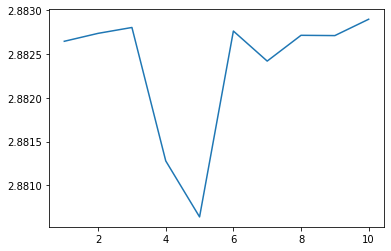

In [3]:
#R = np.array([[1,2,3],[1,2,3],[1,2,3]])
#V = np.array([[1,2,3],[1,2,3],[1,2,3]])+1
np.random.seed(0)

d1 = 10
d2 = 2
R  = np.random.rand(d1,d2)
V  = np.random.rand(d1,d2)
bv = np.random.rand(d2)
ba = np.random.rand(d2)
la = 0.5

ax = 0
mu = np.expand_dims((np.sum(R * V, axis=ax)/ np.sum(R, axis=ax)), axis=0)
s2 = (np.sum(R * (V-mu)**2, axis=ax)/ np.sum(R, axis=ax))
si = np.sqrt(s2)
sl = np.log(si)
co = (bv + sl) * np.sum(R, axis=ax)
ac = (1 / (1 + np.exp(-(la*(ba - np.sum(co))))))






pn = 1/np.sqrt(2*math.pi*s2) * np.exp(-((V-mu)**2 / 2*s2))
pl = -((V-mu)**2 / 2*s2) - sl - np.log(2*math.pi)/2




R, V, mu, s2, si, sl, pn, pl, (np.round(pl - np.log(pn), 10))

xa = np.arange(1,len(pn[:,0])+1,1)

plt.plot(xa, pn[:,1])

In [4]:
(1 / (1+np.exp(-R)))

array([[0.63386027, 0.6715468 ],
       [0.64628827, 0.63294764],
       [0.60435748, 0.65608461],
       [0.60768396, 0.70925592],
       [0.72385455, 0.59470289],
       [0.68820161, 0.62922533],
       [0.63831185, 0.71618109],
       [0.51775155, 0.52176856],
       [0.50505443, 0.6969086 ],
       [0.68528272, 0.70474823]])

### CN EM from Git

In [5]:
class PrimaryCaps(nn.Module):
    r"""Creates a primary convolutional capsule layer
    that outputs a pose matrix and an activation.
    Note that for computation convenience, pose matrix
    are stored in first part while the activations are
    stored in the second part.
    Args:
        A: output of the normal conv layer
        B: number of types of capsules
        K: kernel size of convolution
        P: size of pose matrix is P*P
        stride: stride of convolution
    Shape:
        input:  (*, A, h, w)
        output: (*, h', w', B*(P*P+1))
        h', w' is computed the same way as convolution layer
        parameter size is: K*K*A*B*P*P + B*P*P
    """
    def __init__(self, A=32, B=32, K=1, P=4, stride=1):
        super(PrimaryCaps, self).__init__()
        self.pose = nn.Conv2d(in_channels=A, out_channels=B*P*P,
                            kernel_size=K, stride=stride, bias=True)
        self.a = nn.Conv2d(in_channels=A, out_channels=B,
                            kernel_size=K, stride=stride, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        p = self.pose(x)
        a = self.a(x)
        a = self.sigmoid(a)
        out = torch.cat([p, a], dim=1)
        out = out.permute(0, 2, 3, 1)
        return out



In [6]:
class ConvCaps(nn.Module):
    r"""Create a convolutional capsule layer
    that transfer capsule layer L to capsule layer L+1
    by EM routing.
    Args:
        B: input number of types of capsules
        C: output number on types of capsules
        K: kernel size of convolution
        P: size of pose matrix is P*P
        stride: stride of convolution
        iters: number of EM iterations
        coor_add: use scaled coordinate addition or not
        w_shared: share transformation matrix across w*h.
    Shape:
        input:  (*, h,  w, B*(P*P+1))
        output: (*, h', w', C*(P*P+1))
        h', w' is computed the same way as convolution layer
        parameter size is: K*K*B*C*P*P + B*P*P
    """
    def __init__(self, B=32, C=32, K=3, P=4, stride=2, iters=3,
                 coor_add=False, w_shared=False):
        super(ConvCaps, self).__init__()
        # TODO: lambda scheduler
        # Note that .contiguous() for 3+ dimensional tensors is very slow
        self.B = B
        self.C = C
        self.K = K
        self.P = P
        self.psize = P*P
        self.stride = stride
        self.iters = iters
        self.coor_add = coor_add
        self.w_shared = w_shared
        # constant
        self.eps = 1e-8
        self._lambda = 1e-03
        self.ln_2pi = torch.cuda.FloatTensor(1).fill_(math.log(2*math.pi))
        # params
        # Note that \beta_u and \beta_a are per capsule type,
        # which are stated at https://openreview.net/forum?id=HJWLfGWRb&noteId=rJUY2VdbM
        self.beta_u = nn.Parameter(torch.zeros(C))
        self.beta_a = nn.Parameter(torch.zeros(C))
        # Note that the total number of trainable parameters between
        # two convolutional capsule layer types is 4*4*k*k
        # and for the whole layer is 4*4*k*k*B*C,
        # which are stated at https://openreview.net/forum?id=HJWLfGWRb&noteId=r17t2UIgf
        self.weights = nn.Parameter(torch.randn(1, K*K*B, C, P, P))
        # op
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=2)

    def m_step(self, a_in, r, v, eps, b, B, C, psize):
        """
            \mu^h_j = \dfrac{\sum_i r_{ij} V^h_{ij}}{\sum_i r_{ij}}
            (\sigma^h_j)^2 = \dfrac{\sum_i r_{ij} (V^h_{ij} - mu^h_j)^2}{\sum_i r_{ij}}
            cost_h = (\beta_u + log \sigma^h_j) * \sum_i r_{ij}
            a_j = logistic(\lambda * (\beta_a - \sum_h cost_h))
            Input:
                a_in:      (b, C, 1)
                r:         (b, B, C, 1)
                v:         (b, B, C, P*P)
            Local:
                cost_h:    (b, C, P*P)
                r_sum:     (b, C, 1)
            Output:
                a_out:     (b, C, 1)
                mu:        (b, 1, C, P*P)
                sigma_sq:  (b, 1, C, P*P)
        """
        r = r * a_in
        r = r / (r.sum(dim=2, keepdim=True) + eps)
        r_sum = r.sum(dim=1, keepdim=True)
        coeff = r / (r_sum + eps)
        coeff = coeff.view(b, B, C, 1)

        mu = torch.sum(coeff * v, dim=1, keepdim=True)
        sigma_sq = torch.sum(coeff * (v - mu)**2, dim=1, keepdim=True) + eps

        r_sum = r_sum.view(b, C, 1)
        sigma_sq = sigma_sq.view(b, C, psize)
        cost_h = (self.beta_u.view(C, 1) + torch.log(sigma_sq.sqrt())) * r_sum

        a_out = self.sigmoid(self._lambda*(self.beta_a - cost_h.sum(dim=2)))
        sigma_sq = sigma_sq.view(b, 1, C, psize)

        return a_out, mu, sigma_sq

    def e_step(self, mu, sigma_sq, a_out, v, eps, b, C):
        """
            ln_p_j = sum_h \dfrac{(\V^h_{ij} - \mu^h_j)^2}{2 \sigma^h_j}
                    - sum_h ln(\sigma^h_j) - 0.5*\sum_h ln(2*\pi)
            r = softmax(ln(a_j*p_j))
              = softmax(ln(a_j) + ln(p_j))
            Input:
                mu:        (b, 1, C, P*P)
                sigma:     (b, 1, C, P*P)
                a_out:     (b, C, 1)
                v:         (b, B, C, P*P)
            Local:
                ln_p_j_h:  (b, B, C, P*P)
                ln_ap:     (b, B, C, 1)
            Output:
                r:         (b, B, C, 1)
        """
        ln_p_j_h = -1. * (v - mu)**2 / (2 * sigma_sq) \
                    - torch.log(sigma_sq.sqrt()) \
                    - 0.5*self.ln_2pi

        ln_ap = ln_p_j_h.sum(dim=3) + torch.log(a_out.view(b, 1, C))
        r = self.softmax(ln_ap)
        return r

    def caps_em_routing(self, v, a_in, C, eps):
        """
            Input:
                v:         (b, B, C, P*P)
                a_in:      (b, C, 1)
            Output:
                mu:        (b, 1, C, P*P)
                a_out:     (b, C, 1)
            Note that some dimensions are merged
            for computation convenient, that is
            `b == batch_size*oh*ow`,
            `B == self.K*self.K*self.B`,
            `psize == self.P*self.P`
        """
        b, B, c, psize = v.shape
        assert c == C
        assert (b, B, 1) == a_in.shape

        r = torch.cuda.FloatTensor(b, B, C).fill_(1./C)
        for iter_ in range(self.iters):
            a_out, mu, sigma_sq = self.m_step(a_in, r, v, eps, b, B, C, psize)
            if iter_ < self.iters - 1:
                r = self.e_step(mu, sigma_sq, a_out, v, eps, b, C)

        return mu, a_out

    def add_pathes(self, x, B, K, psize, stride):
        """
            Shape:
                Input:     (b, H, W, B*(P*P+1))
                Output:    (b, H', W', K, K, B*(P*P+1))
        """
        b, h, w, c = x.shape
        assert h == w
        assert c == B*(psize+1)
        oh = ow = int(((h - K )/stride)+ 1) # moein - changed from: oh = ow = int((h - K + 1) / stride)
        idxs = [[(h_idx + k_idx) \
                for k_idx in range(0, K)] \
                for h_idx in range(0, h - K + 1, stride)]
        x = x[:, idxs, :, :]
        x = x[:, :, :, idxs, :]
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        return x, oh, ow

    def transform_view(self, x, w, C, P, w_shared=False):
        """
            For conv_caps:
                Input:     (b*H*W, K*K*B, P*P)
                Output:    (b*H*W, K*K*B, C, P*P)
            For class_caps:
                Input:     (b, H*W*B, P*P)
                Output:    (b, H*W*B, C, P*P)
        """
        b, B, psize = x.shape
        assert psize == P*P

        x = x.view(b, B, 1, P, P)
        if w_shared:
            hw = int(B / w.size(1))
            w = w.repeat(1, hw, 1, 1, 1)

        w = w.repeat(b, 1, 1, 1, 1)
        x = x.repeat(1, 1, C, 1, 1)
        v = torch.matmul(x, w)
        v = v.view(b, B, C, P*P)
        return v

    def add_coord(self, v, b, h, w, B, C, psize):
        """
            Shape:
                Input:     (b, H*W*B, C, P*P)
                Output:    (b, H*W*B, C, P*P)
        """
        assert h == w
        v = v.view(b, h, w, B, C, psize)
        coor = torch.arange(h, dtype=torch.float32) / h
        coor_h = torch.cuda.FloatTensor(1, h, 1, 1, 1, self.psize).fill_(0.)
        coor_w = torch.cuda.FloatTensor(1, 1, w, 1, 1, self.psize).fill_(0.)
        coor_h[0, :, 0, 0, 0, 0] = coor
        coor_w[0, 0, :, 0, 0, 1] = coor
        v = v + coor_h + coor_w
        v = v.view(b, h*w*B, C, psize)
        return v

    def forward(self, x):
        b, h, w, c = x.shape
        if not self.w_shared:
            # add patches
            x, oh, ow = self.add_pathes(x, self.B, self.K, self.psize, self.stride)

            # transform view
            p_in = x[:, :, :, :, :, :self.B*self.psize].contiguous()
            a_in = x[:, :, :, :, :, self.B*self.psize:].contiguous()
            p_in = p_in.view(b*oh*ow, self.K*self.K*self.B, self.psize)
            a_in = a_in.view(b*oh*ow, self.K*self.K*self.B, 1)
            v = self.transform_view(p_in, self.weights, self.C, self.P)

            # em_routing
            p_out, a_out = self.caps_em_routing(v, a_in, self.C, self.eps)
            p_out = p_out.view(b, oh, ow, self.C*self.psize)
            a_out = a_out.view(b, oh, ow, self.C)
            out = torch.cat([p_out, a_out], dim=3)
        else:
            assert c == self.B*(self.psize+1)
            assert 1 == self.K
            assert 1 == self.stride
            p_in = x[:, :, :, :self.B*self.psize].contiguous()
            p_in = p_in.view(b, h*w*self.B, self.psize)
            a_in = x[:, :, :, self.B*self.psize:].contiguous()
            a_in = a_in.view(b, h*w*self.B, 1)

            # transform view
            v = self.transform_view(p_in, self.weights, self.C, self.P, self.w_shared)

            # coor_add
            if self.coor_add:
                v = self.add_coord(v, b, h, w, self.B, self.C, self.psize)

            # em_routing
            _, out = self.caps_em_routing(v, a_in, self.C, self.eps)

        return out


In [7]:
class CapsNet(nn.Module):
    """A network with one ReLU convolutional layer followed by
    a primary convolutional capsule layer and two more convolutional capsule layers.
    Suppose image shape is 28x28x1, the feature maps change as follows:
    1. ReLU Conv1
        (_, 1, 28, 28) -> 5x5 filters, 32 out channels, stride 2 with padding
        x -> (_, 32, 14, 14)
    2. PrimaryCaps
        (_, 32, 14, 14) -> 1x1 filter, 32 out capsules, stride 1, no padding
        x -> pose: (_, 14, 14, 32x4x4), activation: (_, 14, 14, 32)
    3. ConvCaps1
        (_, 14, 14, 32x(4x4+1)) -> 3x3 filters, 32 out capsules, stride 2, no padding
        x -> pose: (_, 6, 6, 32x4x4), activation: (_, 6, 6, 32)
    4. ConvCaps2
        (_, 6, 6, 32x(4x4+1)) -> 3x3 filters, 32 out capsules, stride 1, no padding
        x -> pose: (_, 4, 4, 32x4x4), activation: (_, 4, 4, 32)
    5. ClassCaps
        (_, 4, 4, 32x(4x4+1)) -> 1x1 conv, 10 out capsules
        x -> pose: (_, 10x4x4), activation: (_, 10)
        Note that ClassCaps only outputs activation for each class
    Args:
        A: output channels of normal conv
        B: output channels of primary caps
        C: output channels of 1st conv caps
        D: output channels of 2nd conv caps
        E: output channels of class caps (i.e. number of classes)
        K: kernel of conv caps
        P: size of square pose matrix
        iters: number of EM iterations
        ...
    """
    def __init__(self, A=32, B=32, C=32, D=32, E=10, K=3, P=4, iters=3):
        super(CapsNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=A,
                               kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=A, eps=0.001,
                                 momentum=0.1, affine=True)
        self.relu1 = nn.ReLU(inplace=False)
        self.primary_caps = PrimaryCaps(A, B, 1, P, stride=1)
        self.conv_caps1 = ConvCaps(B, C, K, P, stride=2, iters=iters)
        self.conv_caps2 = ConvCaps(C, D, K, P, stride=1, iters=iters)
        self.class_caps = ConvCaps(D, E, 1, P, stride=1, iters=iters,
                                        coor_add=True, w_shared=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.primary_caps(x)
        x = self.conv_caps1(x)
        x = self.conv_caps2(x)
        x = self.class_caps(x)
        return x

    def forward_debug(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.primary_caps(x)
        x = self.conv_caps1(x)
        x = self.conv_caps2(x)
        x = self.class_caps(x)
        return x

In [8]:
def capsules(**kwargs):
    """Constructs a CapsNet model.
    """
    model = CapsNet(**kwargs)
    return model

In [9]:
'''
TEST
Run this code with:
```
python -m capsules.py
```
'''
#if __name__ == '__main__':
model = capsules(E=10)
print(model)

CapsNet(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (primary_caps): PrimaryCaps(
    (pose): Conv2d(32, 512, kernel_size=(1, 1), stride=(1, 1))
    (a): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
    (sigmoid): Sigmoid()
  )
  (conv_caps1): ConvCaps(
    (sigmoid): Sigmoid()
    (softmax): Softmax(dim=2)
  )
  (conv_caps2): ConvCaps(
    (sigmoid): Sigmoid()
    (softmax): Softmax(dim=2)
  )
  (class_caps): ConvCaps(
    (sigmoid): Sigmoid()
    (softmax): Softmax(dim=2)
  )
)


In [10]:
class SpreadLoss(_Loss):

    def __init__(self, m_min=0.2, m_max=0.9, num_class=10):
        super(SpreadLoss, self).__init__()
        self.m_min = m_min
        self.m_max = m_max
        self.num_class = num_class

    def forward(self, x, target, r):
        b, E = x.shape
        assert E == self.num_class
        margin = self.m_min + (self.m_max - self.m_min)*r

        at = torch.cuda.FloatTensor(b).fill_(0)
        for i, lb in enumerate(target):
            at[i] = x[i][lb]
        at = at.view(b, 1).repeat(1, E)

        zeros = x.new_zeros(x.shape)
        loss = torch.max(margin - (at - x), zeros)
        loss = loss**2
        loss = loss.sum() / b - margin**2

        return loss

### Test model

In [11]:
ds_train = datasets.MNIST(root='../../data', train=True, download=True, transform=T.ToTensor())
ds_valid = datasets.MNIST(root="../../data", train=False, download=True, transform=T.ToTensor())

In [12]:
dl_train = torch.utils.data.DataLoader(ds_train, 
                                        batch_size=16, 
                                        shuffle=True,
                                        num_workers=4)

In [13]:
x, y = next(iter(dl_train))

x.shape, y

(torch.Size([16, 1, 28, 28]),
 tensor([0, 7, 7, 7, 7, 7, 6, 4, 6, 6, 0, 1, 4, 8, 4, 1]))

In [14]:
device = torch.device("cuda")

#CN = CapsNet()
#CN.to(device)

#o = CN.forward_debug(x.to(device))

#o.shape

In [15]:
model = CapsNet()
model = model.to(device)

count_parameters(model)

319028

In [17]:
loss_func = SpreadLoss(num_class=10, m_min=0.2, m_max=0.9)
optimizer = optim.Adam(model.parameters(), lr = 0.01) 

In [19]:
num_epochs = 10
train_len = len(dl_train)
model.train()
for epoch in range(num_epochs):
    for idx, (x, y_true) in enumerate(dl_train):
        x = x.to(device)
        y_true = y_true.to(device)
        optimizer.zero_grad()
        y_pred = model(x)
        r = (1.*idx + (epoch-1)*train_len) / (num_epochs*train_len)
        loss = loss_func(y_pred, y_true,r)         
        loss.backward()
        optimizer.step()
        
        if idx % 1000 == 0:
            print("Epoch[{}/{}] - step {} loss: {:.4f}".format(epoch, num_epochs, idx, loss.item()))

RuntimeError: CUDA out of memory. Tried to allocate 324.00 MiB (GPU 0; 7.79 GiB total capacity; 6.46 GiB already allocated; 95.94 MiB free; 6.59 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### tf positional addition encoding

In [2]:
import tensorflow as tf
import numpy as np

In [6]:
# Spatial output of ConvCaps2 is 4x4
v1 = [[[8.],  [12.], [16.], [20.]],
      [[8.],  [12.], [16.], [20.]],
      [[8.],  [12.], [16.], [20.]],
      [[8.],  [12.], [16.], [20.]],
     ]

v2 = [[[8.],  [8.],  [8.],  [8]],
      [[12.], [12.], [12.], [12.]],
      [[16.], [16.], [16.], [16.]],
      [[20.], [20.], [20.], [20.]]
         ]

c1 = np.array(v1, dtype=np.float32) / 28.0
c2 = np.array(v2, dtype=np.float32) / 28.0


c1.shape,c2.shape

((4, 4, 1), (4, 4, 1))

In [7]:
def coord_addition(votes, H, W):
    """Coordinate addition.

    :param votes: (24, 4, 4, 32, 10, 16)
    :param H, W: spaital height and width 4

    :return votes: (24, 4, 4, 32, 10, 16)
    """
    coordinate_offset_hh = tf.reshape(
      (tf.range(H, dtype=tf.float32) + 0.50) / H, [1, H, 1, 1, 1]
    )
    coordinate_offset_h0 = tf.constant(
      0.0, shape=[1, H, 1, 1, 1], dtype=tf.float32
    )
    coordinate_offset_h = tf.stack(
      [coordinate_offset_hh, coordinate_offset_h0] + [coordinate_offset_h0 for _ in range(14)], axis=-1
    )  # (1, 4, 1, 1, 1, 16)

    coordinate_offset_ww = tf.reshape(
      (tf.range(W, dtype=tf.float32) + 0.50) / W, [1, 1, W, 1, 1]
    )
    coordinate_offset_w0 = tf.constant(
      0.0, shape=[1, 1, W, 1, 1], dtype=tf.float32
    )
    coordinate_offset_w = tf.stack(
      [coordinate_offset_w0, coordinate_offset_ww] + [coordinate_offset_w0 for _ in range(14)], axis=-1
    ) # (1, 1, 4, 1, 1, 16)

    # (24, 4, 4, 32, 10, 16)
    votes = votes + coordinate_offset_h + coordinate_offset_w

    return votes


In [48]:
np.random.seed(0)
a = np.random.rand(24, 4, 4, 32, 10, 16)
print(a.shape)


b = coord_addition(votes=a, H=4, W=4)

c = b-a
p = 3
c[0,:,:,31,9,0]

(24, 4, 4, 32, 10, 16)


<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.125     , 0.12500001, 0.12500006, 0.125     ],
       [0.375     , 0.375     , 0.37499994, 0.375     ],
       [0.625     , 0.62499994, 0.625     , 0.625     ],
       [0.875     , 0.87499994, 0.875     , 0.875     ]], dtype=float32)>